### DLP Lab6
Goal of this lab is to implement a conditional GAN to generate synthetic images according to different conditions
1. Shape: cube, sphere, cylinder
2. Color: gray, red, blue, green, brown, purple, cyan, yellow

#### Implement detail
1. Implement training, testing functions, and dataloader
2. Choose your conditional GAN architecture
3. Design your generator and discriminator
4. Choose your loss function
5. Output the results based on test.json and new_test.json (will be released before demo)

Date: 2020/05/

In [1]:
import numpy as np
import json
import random
import time
import gc
import math
from PIL import Image
import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.utils import data
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from evaluator import evaluation_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [3]:
def show_result(G_losses, D_losses, save = False, path = './img/training_loss.png'):      
    plt.figure(figsize=(10, 6))
    x = range(len(G_losses))
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title("Training Loss Curve", fontsize=18)
    plt.plot(x, G_losses, label='G_loss')
    plt.plot(x, D_losses, label='D_loss')
    plt.legend()
    plt.show()
    
    if save:
        plt.savefig(path) 

### Dataloader

In [4]:
def get_data(mode):
    assert mode == 'train' or mode == 'test'
    data = json.load(open('./data/'+mode+'.json', 'r'))
    if mode == 'train':
        data = [i for i in data.items()]
    return data

def get_objectDic():
    return json.load(open('./data/objects.json', 'r'))

In [5]:
class GANLoader(data.Dataset):
    def __init__(self, mode, image_size=64):
        self.mode = mode   
        self.data = get_data(mode)
        self.obj_dict = get_objectDic()
        self.transformation = transforms.Compose([
                                  transforms.Resize(image_size),
                                  transforms.CenterCrop(image_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == 'train': 
            img_name = self.data[index][0]
            objects = [self.obj_dict[obj] for obj in self.data[index][1]]

            # image preprocess
            img = np.array(Image.open('./data/iclevr/'+img_name))[...,:-1]
            img = self.transformation(Image.fromarray(img))
            
            # condition embedding - one hot
            condition = torch.zeros(24)
            condition = torch.tensor([v+1 if i in objects else v for i,v in enumerate(condition)])
            
            data = (img, condition)
        else:
            # condition embedding - one hot
            objects = [self.obj_dict[obj] for obj in self.data[index]]
            condition = torch.zeros(24)
            data = torch.tensor([v+1 if i in objects else v for i,v in enumerate(condition)])
        
        return data     

In [6]:
trainset = GANLoader('train', image_size=64)
print (trainset[0])
testset = GANLoader('test', image_size=64)
print (testset[0])

(tensor([[[-0.1765, -0.1686, -0.1765,  ..., -0.1765, -0.1843, -0.1765],
         [-0.1686, -0.1686, -0.1686,  ..., -0.1765, -0.1843, -0.1843],
         [-0.1686, -0.1686, -0.1686,  ..., -0.1843, -0.1843, -0.1765],
         ...,
         [-0.0431, -0.0431, -0.0353,  ...,  0.1608,  0.1608,  0.1608],
         [-0.0431, -0.0353, -0.0353,  ...,  0.1608,  0.1608,  0.1686],
         [-0.0431, -0.0353, -0.0353,  ...,  0.1608,  0.1608,  0.1608]],

        [[-0.1765, -0.1686, -0.1765,  ..., -0.1765, -0.1843, -0.1765],
         [-0.1765, -0.1686, -0.1765,  ..., -0.1765, -0.1843, -0.1843],
         [-0.1765, -0.1686, -0.1686,  ..., -0.1843, -0.1843, -0.1843],
         ...,
         [-0.0510, -0.0510, -0.0431,  ...,  0.1451,  0.1451,  0.1373],
         [-0.0510, -0.0431, -0.0431,  ...,  0.1451,  0.1451,  0.1451],
         [-0.0510, -0.0510, -0.0431,  ...,  0.1451,  0.1451,  0.1451]],

        [[-0.1765, -0.1765, -0.1765,  ..., -0.1765, -0.1843, -0.1765],
         [-0.1765, -0.1686, -0.1765,  ..., -

### Models

In [7]:
# custom weights initialization called
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_size=100, ngf=64):
        super(Generator, self).__init__()
        self.ngf = ngf
        self.conditional = nn.Sequential(
            nn.Linear(24, 100), 
            nn.ReLU(True)
        )
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d((latent_size+100), ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, input, condition):
        condition = self.conditional(condition)
        input = torch.cat((input, condition.view(input.size(0), -1, 1, 1)), 1)
        return self.main(input)

## Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ndf=64):
        super(Discriminator, self).__init__()
        self.ndf = ndf
        self.linear = nn.Sequential(
            nn.Linear(24, ndf*ndf), 
            nn.ReLU(True)
        )
        
        self.main = nn.Sequential(
            # input is 4 x 64 x 64
            nn.Conv2d(4, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input, condition):
        condition = self.linear(condition).view(input.size(0), 1, self.ndf, self.ndf)
        input = torch.cat((input, condition), 1)
        return self.main(input)

### Training

In [10]:
def learning_schedule(epoch):
    lr_dict={400:1e-4, 300:2e-4, 200:3e-4, 100:4e-4, 0:5e-4}
    for k in lr_dict.keys():
        if epoch >= k:
            return lr_dict[k], lr_dict[k]

In [11]:
def training(G, D, image_size, latent_size, lr_G, lr_D, batch_size, num_epochs):
    start = time.time()
    real_label = 1
    fake_label = 0
    
    # recording list
    G_losses = []
    D_losses = []
    
    # init dataloader 
    trainset = GANLoader('train', image_size=64)
    trainloader = data.DataLoader(trainset, batch_size, num_workers=2, shuffle=True)

    # init criterion & optimizer
    criterion = nn.BCELoss()
    optimizerG = optim.Adam(G.parameters(), lr=lr_G, betas=(2e-4, 0.999))
    schedulerG = StepLR(optimizerG, step_size=130, gamma=0.5)
    optimizerD = optim.Adam(D.parameters(), lr=lr_D, betas=(2e-4, 0.999))
    schedulerD = StepLR(optimizerD, step_size=80, gamma=0.5)
    
    # init fixed noise
    fixed_noise = torch.randn(32, latent_size, 1, 1, device=device)
    
    for epoch in range(num_epochs):
        
        for idx, datas in enumerate(trainloader):
            b_size = datas[0].size(0)
            img = datas[0].to(device)
            condition = datas[1].to(device)
            
            #------part1 - train discriminator: maximize log(D(x)) + log(1 - D(G(z)))-----#
            ## all real batch
            D.zero_grad()
            label = torch.full((b_size,), real_label, device=device)
            output = D(img, condition).view(-1)
            
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item() 

            ## all fake batch
            noise = torch.randn(b_size, latent_size, 1, 1, device=device)
            fake = G(noise, condition)
            label.fill_(fake_label)
            
            output = D(fake.detach(), condition).view(-1)
            
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            
            errD = errD_real + errD_fake
            
            # Update D
            optimizerD.step()
            
            #------part2 - train generator: maximize log(D(G(z)))-----#
            G.zero_grad()
            label.fill_(real_label)
            output = D(fake, condition).view(-1)
            
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            
            # Update G
            optimizerG.step()
            
        # lr schedule
        schedulerG.step()
        schedulerD.step()

        acc,_ = testing(G, fixed_noise, latent_size, batch_size)
        if acc>0.5556 :
            print ("Model save...")
            torch.save(G, "./models/G_{:.4f}.ckpt".format(acc))
            torch.save(D, "./models/D_{:.4f}.ckpt".format(acc))
            
        if epoch % 1 == 0:
            print('%s (%d %d%%) Accuracy: %.4f Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                          % (timeSince(start, (epoch+1)/num_epochs), epoch, epoch/num_epochs * 100, 
                              acc, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        collected = gc.collect()
        torch.cuda.empty_cache()
    return G_losses, D_losses

### Testing

In [12]:
def testing(G, noise=None, latent_size=100, batch_size=32):
    E = evaluation_model()
    
    img_list = []
    acc_list = []

    if noise is None:
        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
    
    # init dataloader 
    testset = GANLoader('test')
    testloader = data.DataLoader(testset, batch_size, num_workers=2)
    
    with torch.no_grad():
        for condition in testloader:
            condition = condition.to(device)
            # b_size = condition.size(0)
            fake = G(noise, condition).detach()
            
            acc_list.append(E.eval(fake, condition))
            img_list.append(make_grid(fake, nrow=8, padding=2, normalize=True).cpu())

    return sum(acc_list)/len(acc_list), img_list

### Main

0m 36s (- 425m 19s) (0 0%) Accuracy: 0.0833 Loss_D: 0.9635 Loss_G: 9.5629 D(x): 0.9243 D(G(z)): 0.5736 / 0.0002
1m 12s (- 421m 21s) (1 0%) Accuracy: 0.1250 Loss_D: 0.3467 Loss_G: 4.1249 D(x): 0.8704 D(G(z)): 0.1077 / 0.0202
1m 48s (- 420m 4s) (2 0%) Accuracy: 0.1111 Loss_D: 0.6145 Loss_G: 2.2641 D(x): 0.8097 D(G(z)): 0.0582 / 0.1260
2m 25s (- 422m 41s) (3 0%) Accuracy: 0.1389 Loss_D: 0.2911 Loss_G: 3.1489 D(x): 0.8585 D(G(z)): 0.1081 / 0.0637
3m 2s (- 421m 49s) (4 0%) Accuracy: 0.1389 Loss_D: 0.4490 Loss_G: 3.6621 D(x): 0.9249 D(G(z)): 0.2818 / 0.0303
3m 38s (- 420m 39s) (5 0%) Accuracy: 0.0972 Loss_D: 0.3280 Loss_G: 2.8256 D(x): 0.8216 D(G(z)): 0.0291 / 0.0858
4m 14s (- 419m 53s) (6 0%) Accuracy: 0.1389 Loss_D: 1.6871 Loss_G: 2.1057 D(x): 0.3454 D(G(z)): 0.0026 / 0.3154
4m 50s (- 418m 22s) (7 1%) Accuracy: 0.1250 Loss_D: 0.4310 Loss_G: 2.0609 D(x): 0.8141 D(G(z)): 0.0299 / 0.1435
5m 26s (- 417m 48s) (8 1%) Accuracy: 0.0833 Loss_D: 0.1911 Loss_G: 3.0783 D(x): 0.8968 D(G(z)): 0.0621 / 0

44m 31s (- 376m 38s) (73 10%) Accuracy: 0.3750 Loss_D: 0.0491 Loss_G: 4.6295 D(x): 0.9797 D(G(z)): 0.0274 / 0.0129
45m 7s (- 376m 6s) (74 10%) Accuracy: 0.3472 Loss_D: 0.2468 Loss_G: 2.4998 D(x): 0.8602 D(G(z)): 0.0725 / 0.1350
45m 43s (- 375m 28s) (75 10%) Accuracy: 0.3194 Loss_D: 0.0311 Loss_G: 5.4320 D(x): 0.9724 D(G(z)): 0.0028 / 0.0055
46m 18s (- 374m 43s) (76 10%) Accuracy: 0.3194 Loss_D: 0.2353 Loss_G: 2.3844 D(x): 0.8338 D(G(z)): 0.0172 / 0.1399
46m 53s (- 373m 58s) (77 11%) Accuracy: 0.3611 Loss_D: 0.1651 Loss_G: 3.9850 D(x): 0.9527 D(G(z)): 0.1032 / 0.0257
47m 28s (- 373m 12s) (78 11%) Accuracy: 0.3472 Loss_D: 0.4703 Loss_G: 8.3983 D(x): 0.9950 D(G(z)): 0.3475 / 0.0014
48m 3s (- 372m 29s) (79 11%) Accuracy: 0.3333 Loss_D: 0.0477 Loss_G: 4.2507 D(x): 0.9668 D(G(z)): 0.0123 / 0.0195
48m 39s (- 371m 53s) (80 11%) Accuracy: 0.3611 Loss_D: 0.0638 Loss_G: 4.2389 D(x): 0.9656 D(G(z)): 0.0266 / 0.0203
49m 15s (- 371m 14s) (81 11%) Accuracy: 0.3333 Loss_D: 0.0367 Loss_G: 4.8751 D(x): 

87m 17s (- 331m 13s) (145 20%) Accuracy: 0.3889 Loss_D: 0.0725 Loss_G: 3.6656 D(x): 0.9574 D(G(z)): 0.0269 / 0.0307
87m 53s (- 330m 37s) (146 20%) Accuracy: 0.4306 Loss_D: 0.0902 Loss_G: 3.7819 D(x): 0.9663 D(G(z)): 0.0515 / 0.0280
88m 28s (- 329m 59s) (147 21%) Accuracy: 0.3750 Loss_D: 0.2662 Loss_G: 2.7956 D(x): 0.7998 D(G(z)): 0.0136 / 0.0932
89m 4s (- 329m 24s) (148 21%) Accuracy: 0.4028 Loss_D: 0.2173 Loss_G: 5.3155 D(x): 0.9853 D(G(z)): 0.1781 / 0.0060
89m 39s (- 328m 46s) (149 21%) Accuracy: 0.4583 Loss_D: 0.1333 Loss_G: 3.1981 D(x): 0.9301 D(G(z)): 0.0533 / 0.0538
90m 14s (- 328m 7s) (150 21%) Accuracy: 0.4167 Loss_D: 0.0573 Loss_G: 6.1367 D(x): 0.9462 D(G(z)): 0.0009 / 0.0030
90m 50s (- 327m 30s) (151 21%) Accuracy: 0.4722 Loss_D: 0.0555 Loss_G: 4.2782 D(x): 0.9911 D(G(z)): 0.0445 / 0.0172
91m 26s (- 326m 54s) (152 21%) Accuracy: 0.4306 Loss_D: 0.1387 Loss_G: 2.6062 D(x): 0.8916 D(G(z)): 0.0197 / 0.1119
92m 1s (- 326m 17s) (153 21%) Accuracy: 0.3889 Loss_D: 0.1013 Loss_G: 3.32

128m 47s (- 286m 39s) (216 30%) Accuracy: 0.5556 Loss_D: 0.3218 Loss_G: 4.2940 D(x): 0.9257 D(G(z)): 0.2084 / 0.0161
129m 22s (- 286m 3s) (217 31%) Accuracy: 0.5417 Loss_D: 0.5692 Loss_G: 0.5895 D(x): 0.6251 D(G(z)): 0.0086 / 0.6358
129m 57s (- 285m 26s) (218 31%) Accuracy: 0.5139 Loss_D: 0.1249 Loss_G: 3.4183 D(x): 0.9374 D(G(z)): 0.0531 / 0.0407
130m 31s (- 284m 47s) (219 31%) Accuracy: 0.4583 Loss_D: 0.0582 Loss_G: 4.6808 D(x): 0.9538 D(G(z)): 0.0097 / 0.0128
131m 5s (- 284m 8s) (220 31%) Accuracy: 0.4861 Loss_D: 0.1546 Loss_G: 4.6468 D(x): 0.9984 D(G(z)): 0.1352 / 0.0129
131m 39s (- 283m 29s) (221 31%) Accuracy: 0.4861 Loss_D: 0.0997 Loss_G: 3.9169 D(x): 0.9882 D(G(z)): 0.0830 / 0.0233
132m 14s (- 282m 50s) (222 31%) Accuracy: 0.4861 Loss_D: 0.0654 Loss_G: 4.0420 D(x): 0.9600 D(G(z)): 0.0210 / 0.0215
132m 48s (- 282m 13s) (223 31%) Accuracy: 0.4722 Loss_D: 0.0565 Loss_G: 4.2620 D(x): 0.9916 D(G(z)): 0.0465 / 0.0174
133m 22s (- 281m 34s) (224 32%) Accuracy: 0.4722 Loss_D: 0.3547 Los

169m 16s (- 242m 9s) (287 41%) Accuracy: 0.4861 Loss_D: 0.0936 Loss_G: 3.6057 D(x): 0.9662 D(G(z)): 0.0568 / 0.0316
169m 51s (- 241m 33s) (288 41%) Accuracy: 0.5000 Loss_D: 0.0493 Loss_G: 4.0191 D(x): 0.9797 D(G(z)): 0.0280 / 0.0218
170m 26s (- 240m 57s) (289 41%) Accuracy: 0.4722 Loss_D: 0.1229 Loss_G: 3.8786 D(x): 0.8936 D(G(z)): 0.0071 / 0.0270
171m 1s (- 240m 22s) (290 41%) Accuracy: 0.4861 Loss_D: 0.0360 Loss_G: 4.2113 D(x): 0.9906 D(G(z)): 0.0260 / 0.0170
171m 36s (- 239m 46s) (291 41%) Accuracy: 0.4861 Loss_D: 0.0674 Loss_G: 3.6549 D(x): 0.9578 D(G(z)): 0.0232 / 0.0313
172m 11s (- 239m 10s) (292 41%) Accuracy: 0.4722 Loss_D: 0.2248 Loss_G: 3.4611 D(x): 0.8136 D(G(z)): 0.0023 / 0.0490
172m 46s (- 238m 35s) (293 41%) Accuracy: 0.4722 Loss_D: 0.1137 Loss_G: 3.2416 D(x): 0.9182 D(G(z)): 0.0249 / 0.0470
173m 21s (- 237m 59s) (294 42%) Accuracy: 0.4861 Loss_D: 0.0149 Loss_G: 5.5934 D(x): 0.9895 D(G(z)): 0.0043 / 0.0046
173m 55s (- 237m 23s) (295 42%) Accuracy: 0.4722 Loss_D: 0.0243 Lo

210m 58s (- 200m 24s) (358 51%) Accuracy: 0.5278 Loss_D: 0.0356 Loss_G: 4.9431 D(x): 0.9716 D(G(z)): 0.0064 / 0.0086
211m 33s (- 199m 47s) (359 51%) Accuracy: 0.5139 Loss_D: 0.0398 Loss_G: 5.1940 D(x): 0.9658 D(G(z)): 0.0046 / 0.0064
212m 7s (- 199m 11s) (360 51%) Accuracy: 0.5278 Loss_D: 0.0828 Loss_G: 3.4907 D(x): 0.9577 D(G(z)): 0.0379 / 0.0361
212m 41s (- 198m 34s) (361 51%) Accuracy: 0.5139 Loss_D: 0.0973 Loss_G: 3.3529 D(x): 0.9635 D(G(z)): 0.0568 / 0.0404
213m 14s (- 197m 58s) (362 51%) Accuracy: 0.5000 Loss_D: 0.0344 Loss_G: 4.0876 D(x): 0.9925 D(G(z)): 0.0264 / 0.0199
213m 49s (- 197m 22s) (363 51%) Accuracy: 0.4722 Loss_D: 0.0084 Loss_G: 5.4108 D(x): 0.9970 D(G(z)): 0.0054 / 0.0052
214m 23s (- 196m 46s) (364 52%) Accuracy: 0.5000 Loss_D: 0.0119 Loss_G: 5.1332 D(x): 0.9958 D(G(z)): 0.0076 / 0.0071
214m 57s (- 196m 9s) (365 52%) Accuracy: 0.4861 Loss_D: 0.0475 Loss_G: 4.0261 D(x): 0.9951 D(G(z)): 0.0412 / 0.0230
215m 31s (- 195m 33s) (366 52%) Accuracy: 0.5000 Loss_D: 0.0581 Lo

252m 11s (- 158m 20s) (429 61%) Accuracy: 0.5000 Loss_D: 0.0224 Loss_G: 4.0972 D(x): 0.9999 D(G(z)): 0.0220 / 0.0188
252m 45s (- 157m 45s) (430 61%) Accuracy: 0.5139 Loss_D: 0.0695 Loss_G: 3.4044 D(x): 0.9776 D(G(z)): 0.0454 / 0.0371
253m 20s (- 157m 9s) (431 61%) Accuracy: 0.5000 Loss_D: 0.0665 Loss_G: 3.4661 D(x): 0.9904 D(G(z)): 0.0546 / 0.0386
253m 54s (- 156m 34s) (432 61%) Accuracy: 0.4861 Loss_D: 0.0086 Loss_G: 5.1026 D(x): 0.9991 D(G(z)): 0.0076 / 0.0072
254m 29s (- 155m 58s) (433 61%) Accuracy: 0.5000 Loss_D: 0.0247 Loss_G: 4.1840 D(x): 0.9956 D(G(z)): 0.0201 / 0.0176
255m 4s (- 155m 23s) (434 62%) Accuracy: 0.4722 Loss_D: 0.0515 Loss_G: 4.2796 D(x): 0.9636 D(G(z)): 0.0139 / 0.0159
255m 38s (- 154m 47s) (435 62%) Accuracy: 0.4861 Loss_D: 0.0662 Loss_G: 4.3306 D(x): 0.9475 D(G(z)): 0.0110 / 0.0149
256m 12s (- 154m 11s) (436 62%) Accuracy: 0.5000 Loss_D: 0.0646 Loss_G: 3.6875 D(x): 0.9664 D(G(z)): 0.0294 / 0.0291
256m 48s (- 153m 37s) (437 62%) Accuracy: 0.5000 Loss_D: 0.0271 Lo

293m 33s (- 116m 35s) (500 71%) Accuracy: 0.4722 Loss_D: 0.1800 Loss_G: 2.6679 D(x): 0.9824 D(G(z)): 0.1456 / 0.0888
294m 7s (- 116m 0s) (501 71%) Accuracy: 0.4861 Loss_D: 0.0395 Loss_G: 4.4872 D(x): 0.9752 D(G(z)): 0.0139 / 0.0143
294m 42s (- 115m 25s) (502 71%) Accuracy: 0.4722 Loss_D: 0.1646 Loss_G: 3.1546 D(x): 0.8888 D(G(z)): 0.0412 / 0.0512
295m 17s (- 114m 50s) (503 71%) Accuracy: 0.4861 Loss_D: 0.1727 Loss_G: 2.9763 D(x): 0.9026 D(G(z)): 0.0627 / 0.0689
295m 52s (- 114m 14s) (504 72%) Accuracy: 0.4861 Loss_D: 0.0111 Loss_G: 6.6915 D(x): 0.9905 D(G(z)): 0.0015 / 0.0016
296m 27s (- 113m 39s) (505 72%) Accuracy: 0.5139 Loss_D: 0.1351 Loss_G: 3.2921 D(x): 0.9135 D(G(z)): 0.0378 / 0.0434
297m 1s (- 113m 4s) (506 72%) Accuracy: 0.5139 Loss_D: 0.0691 Loss_G: 4.3411 D(x): 0.9480 D(G(z)): 0.0142 / 0.0159
297m 36s (- 112m 28s) (507 72%) Accuracy: 0.5139 Loss_D: 0.0551 Loss_G: 5.6565 D(x): 0.9506 D(G(z)): 0.0035 / 0.0041
298m 10s (- 111m 53s) (508 72%) Accuracy: 0.5278 Loss_D: 0.0585 Loss

/home/user/anaconda3/envs/th1.2/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user/anaconda3/envs/th1.2/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


317m 15s (- 92m 28s) (541 77%) Accuracy: 0.5694 Loss_D: 0.0105 Loss_G: 4.8688 D(x): 0.9986 D(G(z)): 0.0091 / 0.0088
Model save...
317m 50s (- 91m 53s) (542 77%) Accuracy: 0.5694 Loss_D: 0.0424 Loss_G: 4.3284 D(x): 0.9727 D(G(z)): 0.0144 / 0.0150
318m 25s (- 91m 18s) (543 77%) Accuracy: 0.5278 Loss_D: 0.0372 Loss_G: 4.5001 D(x): 0.9792 D(G(z)): 0.0157 / 0.0157
319m 0s (- 90m 43s) (544 77%) Accuracy: 0.5417 Loss_D: 0.0127 Loss_G: 4.7572 D(x): 0.9983 D(G(z)): 0.0109 / 0.0104
319m 35s (- 90m 8s) (545 77%) Accuracy: 0.5417 Loss_D: 0.0235 Loss_G: 4.7116 D(x): 0.9871 D(G(z)): 0.0104 / 0.0104
Model save...
320m 10s (- 89m 33s) (546 78%) Accuracy: 0.5694 Loss_D: 0.0651 Loss_G: 3.8987 D(x): 0.9605 D(G(z)): 0.0237 / 0.0247
Model save...
320m 45s (- 88m 58s) (547 78%) Accuracy: 0.5694 Loss_D: 0.0106 Loss_G: 6.2628 D(x): 0.9917 D(G(z)): 0.0022 / 0.0023
321m 20s (- 88m 23s) (548 78%) Accuracy: 0.5417 Loss_D: 0.0415 Loss_G: 3.7972 D(x): 0.9871 D(G(z)): 0.0280 / 0.0258
321m 55s (- 87m 47s) (549 78%) A

357m 34s (- 52m 5s) (610 87%) Accuracy: 0.5278 Loss_D: 0.0103 Loss_G: 5.1999 D(x): 0.9961 D(G(z)): 0.0063 / 0.0063
358m 10s (- 51m 30s) (611 87%) Accuracy: 0.5417 Loss_D: 0.0772 Loss_G: 2.9657 D(x): 0.9941 D(G(z)): 0.0682 / 0.0600
358m 46s (- 50m 55s) (612 87%) Accuracy: 0.5417 Loss_D: 0.0863 Loss_G: 6.8579 D(x): 0.9206 D(G(z)): 0.0015 / 0.0017
359m 21s (- 50m 19s) (613 87%) Accuracy: 0.5417 Loss_D: 0.0384 Loss_G: 3.7790 D(x): 0.9894 D(G(z)): 0.0273 / 0.0263
359m 56s (- 49m 44s) (614 87%) Accuracy: 0.5417 Loss_D: 0.0468 Loss_G: 3.7611 D(x): 0.9833 D(G(z)): 0.0293 / 0.0284
360m 32s (- 49m 9s) (615 87%) Accuracy: 0.5417 Loss_D: 0.1151 Loss_G: 3.9837 D(x): 0.9119 D(G(z)): 0.0196 / 0.0220
361m 8s (- 48m 34s) (616 88%) Accuracy: 0.5417 Loss_D: 0.0954 Loss_G: 3.6558 D(x): 0.9377 D(G(z)): 0.0292 / 0.0307
361m 43s (- 47m 59s) (617 88%) Accuracy: 0.5417 Loss_D: 0.0961 Loss_G: 2.8767 D(x): 0.9854 D(G(z)): 0.0768 / 0.0685
362m 18s (- 47m 24s) (618 88%) Accuracy: 0.5417 Loss_D: 0.0667 Loss_G: 5.16

399m 5s (- 10m 31s) (681 97%) Accuracy: 0.5139 Loss_D: 0.1136 Loss_G: 3.7230 D(x): 0.9210 D(G(z)): 0.0288 / 0.0297
399m 39s (- 9m 56s) (682 97%) Accuracy: 0.5139 Loss_D: 0.0689 Loss_G: 4.7924 D(x): 0.9435 D(G(z)): 0.0095 / 0.0098
400m 15s (- 9m 21s) (683 97%) Accuracy: 0.5278 Loss_D: 0.0889 Loss_G: 2.9585 D(x): 0.9865 D(G(z)): 0.0713 / 0.0679
400m 50s (- 8m 46s) (684 97%) Accuracy: 0.5139 Loss_D: 0.0716 Loss_G: 3.7439 D(x): 0.9588 D(G(z)): 0.0283 / 0.0285
401m 25s (- 8m 11s) (685 97%) Accuracy: 0.5139 Loss_D: 0.0705 Loss_G: 3.0237 D(x): 0.9905 D(G(z)): 0.0587 / 0.0564
401m 59s (- 7m 36s) (686 98%) Accuracy: 0.5139 Loss_D: 0.2272 Loss_G: 4.2486 D(x): 0.8207 D(G(z)): 0.0161 / 0.0182
402m 34s (- 7m 1s) (687 98%) Accuracy: 0.5278 Loss_D: 0.0782 Loss_G: 3.9114 D(x): 0.9486 D(G(z)): 0.0241 / 0.0245
403m 9s (- 6m 26s) (688 98%) Accuracy: 0.5278 Loss_D: 0.1367 Loss_G: 2.3926 D(x): 0.9947 D(G(z)): 0.1208 / 0.1111
403m 44s (- 5m 51s) (689 98%) Accuracy: 0.5000 Loss_D: 0.0575 Loss_G: 4.2320 D(x):

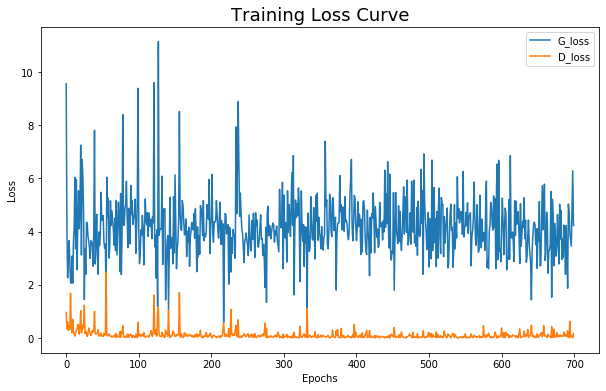

In [13]:
image_size = 64 
latent_size = 100
lr_G = 0.0002
lr_D = 0.0001
batch_size = 128
num_epochs = 700

manualSeed = 87
random.seed(manualSeed)
torch.manual_seed(manualSeed)

G = Generator(latent_size=100, ngf=64).to(device)
G.apply(weights_init)
D = Discriminator(ndf=64).to(device)
D.apply(weights_init)
G_losses, D_losses = training(G, D, image_size, latent_size, lr_G, lr_D, batch_size, num_epochs)
show_result(G_losses, D_losses)

Accuracy: 0.5694


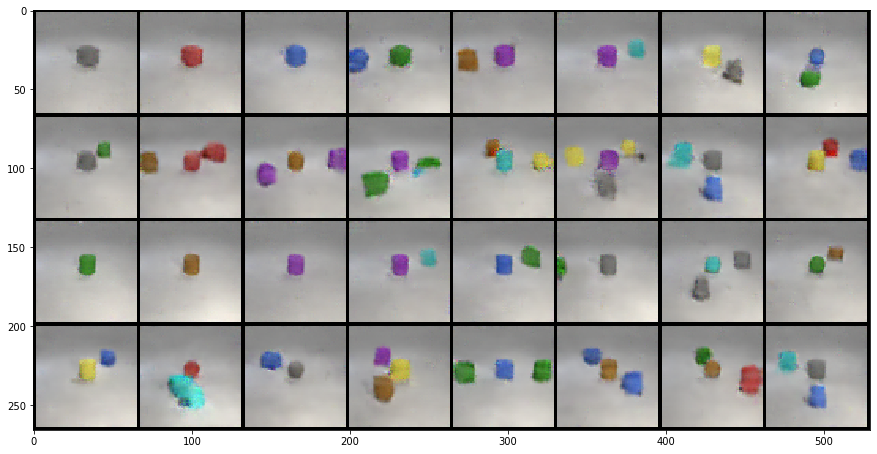

In [42]:
G = torch.load('./models/G_0.5694.ckpt')
acc, imgs = testing(G)
fig = plt.figure(figsize=(15,15))
plt.imshow(np.transpose(imgs[0],(1,2,0)))
print ("Accuracy: %.4f"%(acc))